In [1]:
%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets

import torch
import torch.autograd as agd
import torch.nn as tchnn
import torch.nn.functional as F
import torch.optim as optim
import random

import os, sys
sys.path.append(os.getcwd())
import random

#to get the MNIST dataset from tf
#saved it in file, not needed now, come out of virtual env
#import keras
#from keras.datasets import mnist

/home/udion/Misc/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#some params
DIM = 2048 #bigger than 728, mimicing the model of 2 d gaussian
FIXED_GEN = False
LAMBDA = .1
DISCRI_ITR = 5
BATCHSZ = 256
batchSz = BATCHSZ
TOT_GEN_ITR = 1001#100000

In [3]:
#models of generator and discriminator gen has 28X28 i/o Discri has 28X28 input nodes and 
class Generator(tchnn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.L1 = tchnn.Linear(784, DIM)
        self.L2 = tchnn.Linear(DIM, DIM)
        self.L3 = tchnn.Linear(DIM, DIM)
        self.Ou = tchnn.Linear(DIM,784)
    def forward(self, noise, real_data):
        if FIXED_GEN:
            return noise + real_data
        else:
            x = F.relu(self.L1(noise))
            x = F.relu(self.L2(x))
            x = F.relu(self.L3(x))
            x = self.Ou(x)
            return x.view(-1,784)
    def name(self):
        return 'GENERATOR'

In [4]:
class Discriminator(tchnn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.L1 = tchnn.Linear(784, DIM)
        self.L2 = tchnn.Linear(DIM, DIM)
        self.L3 = tchnn.Linear(DIM, DIM)
        self.Ou = tchnn.Linear(DIM,1)
    def forward(self, x):
            x = F.relu(self.L1(x))
            x = F.relu(self.L2(x))
            x = F.relu(self.L3(x))
            x = self.Ou(x)
            return x.view(-1)
    def name(self):
        return 'DISCRIMINATOR'

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [6]:
#gradient penalty term in objective
def calc_gp(D, real_data, fake_data):
    α = torch.rand(BATCHSZ, 1)
    α = α.expand(real_data.size())
    α = α.cuda()
    
    interpolated = α*real_data + (1-α)*fake_data
    interpolated = interpolated.cuda()
    interpolated = agd.Variable(interpolated, requires_grad=True)
    
    D_interp = D(interpolated)
    
    gradients = agd.grad(outputs=D_interp, inputs=interpolated, grad_outputs=torch.ones(D_interp.size()).cuda()
                        ,create_graph=True, retain_graph=True, only_inputs=True)[0]
    gp = ((gradients.norm(2, dim=1) - 1)**2).mean()*LAMBDA
    return gp

### Data generator, which can generate the data in the required format of a particular batch size

In [36]:
# (MNISTX_train, MNISTy_train), (MNISTX_test, MNISTy_test) = mnist.load_data()
# MNISTX_train = MNISTX_train/255
# MNISTy_test = MNISTX_test/255 #not needed
# print(MNISTX_train.shape)

In [35]:
#test
Zooba = MNISTX_train.reshape(-1,784)
Zooba.shape
Zooba1 = random.sample(list(Zooba), 10)
Zooba1 = np.array(Zooba1)
Zooba1.shape
np.save('MNISTX_train', Zooba)
Zooba2 = np.load('MNISTX_train.npy')
Zooba2.shape

(60000, 784)

In [7]:
MNISTX_train = np.load('MNISTX_train.npy')

In [8]:
def MNIST_gen(X, BATCHSZ):
    X = X.reshape(-1,784) #serialize images
    while(True):
        databatch = random.sample(list(X), BATCHSZ)
        databatch = np.array(databatch)
        yield databatch

MNISTd = MNIST_gen(MNISTX_train, BATCHSZ)

In [9]:
next(MNISTd)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [10]:
#generator plotter
def plotter(batch_data):
    #batch_data = batch_data.numpy()
    n = batch_data.shape[0]
    for i in range(n):
        plt.subplot(3,3,i+1)
        plt.imshow(batch_data[i].reshape(-1,28), cmap='gray', interpolation='none')
    plt.show()

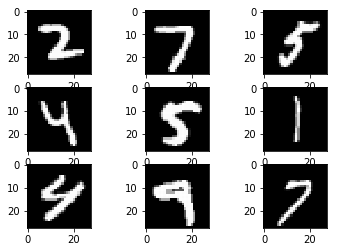

In [11]:
plotter(next(MNISTd)[0:9,:])

In [12]:
#notaion similar to paper
G = Generator().cuda()
D = Discriminator().cuda()
G.apply(weights_init)
D.apply(weights_init)
print(G)
print(D)

Generator (
  (L1): Linear (784 -> 2048)
  (L2): Linear (2048 -> 2048)
  (L3): Linear (2048 -> 2048)
  (Ou): Linear (2048 -> 784)
)
Discriminator (
  (L1): Linear (784 -> 2048)
  (L2): Linear (2048 -> 2048)
  (L3): Linear (2048 -> 2048)
  (Ou): Linear (2048 -> 1)
)


In [13]:
one = torch.FloatTensor([1])
onebar = one * -1
one = one.cuda()
onebar = onebar.cuda()

In [14]:
optD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))
optG = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))

itr: 0 done
showing the first 9 generator output after itr 0:


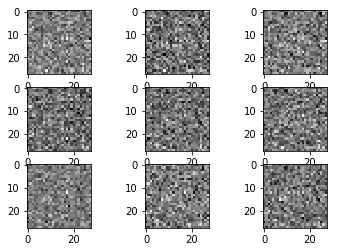

itr: 50 done
itr: 100 done
showing the first 9 generator output after itr 100:


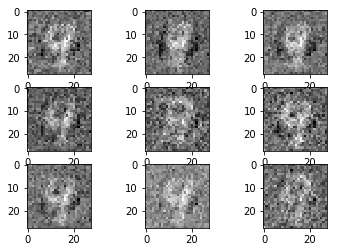

itr: 150 done
itr: 200 done
showing the first 9 generator output after itr 200:


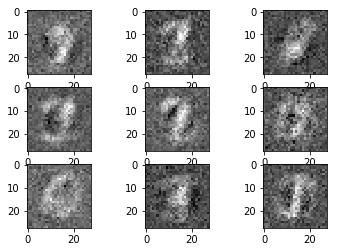

itr: 250 done
itr: 300 done
showing the first 9 generator output after itr 300:


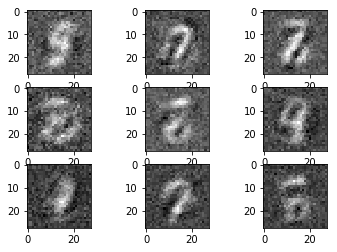

itr: 350 done
itr: 400 done
showing the first 9 generator output after itr 400:


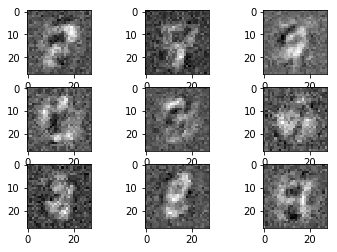

itr: 450 done
itr: 500 done
showing the first 9 generator output after itr 500:


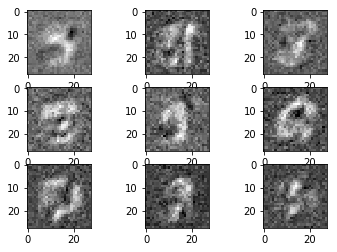

itr: 550 done
itr: 600 done
showing the first 9 generator output after itr 600:


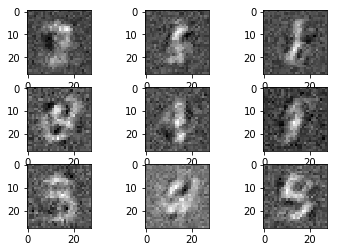

itr: 650 done
itr: 700 done
showing the first 9 generator output after itr 700:


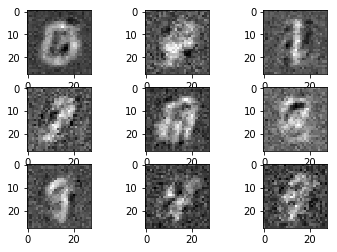

itr: 750 done
itr: 800 done
showing the first 9 generator output after itr 800:


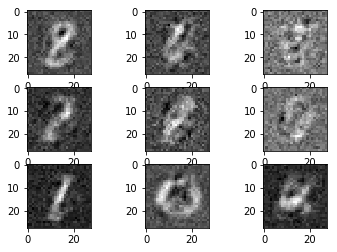

itr: 850 done
itr: 900 done
showing the first 9 generator output after itr 900:


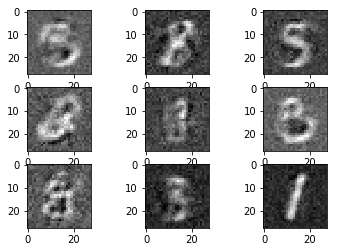

itr: 950 done
itr: 1000 done
showing the first 9 generator output after itr 1000:


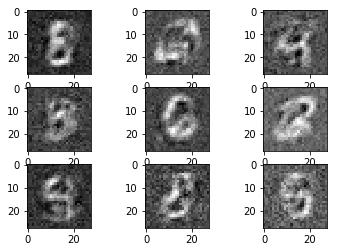

itr: 1050 done


KeyboardInterrupt: 

In [15]:
#trainer
## dont touch unless you want to train
for itr in range(10000):
    ## D training and hence layers paprams should get updated.
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update

    for iter_d in range(DISCRI_ITR):
        #print(iter_d)
        _data = next(MNISTd)
        real_data = torch.Tensor(_data)
        real_data = real_data.cuda()
        real_data_v = agd.Variable(real_data)
        #print(real_data_v)

        D.zero_grad()

        # train with real
        D_real = D(real_data_v)
        D_real = D_real.mean()
        D_real.backward(onebar)

        # train with fake
        noise = torch.randn(BATCHSZ, 784)
        noise = noise.cuda()
        noisev = agd.Variable(noise, volatile=True)  # totally freeze netG
        
        #noisev = agd.Variable(noise)
        gop = G(noisev, real_data_v)
        #print('here3')
        fake = agd.Variable(gop.data)
        inputv = fake
        D_fake = D(inputv)
        D_fake = D_fake.mean()
        D_fake.backward(one)

        # train with gradient penalty
        gradient_penalty = calc_gp(D, real_data_v.data, fake.data)
        gradient_penalty.backward()

        D_cost = D_fake - D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        optD.step()
        #print('discri iter done ', iter_d)
    fake2plot = ''
    if not FIXED_GEN:
        #now the discriminator should not be updating it's weights
        for p in D.parameters():
            p.requires_grad = False  # to avoid computation
        G.zero_grad()

        _data = next(MNISTd)
        real_data = torch.Tensor(_data)
        real_data = real_data.cuda()
        real_data_v = agd.Variable(real_data)

        noise = torch.randn(BATCHSZ, 784)
        noise = noise.cuda()
        noisev = agd.Variable(noise)
        fake = G(noisev, real_data_v)
        fake2plot = fake.cpu().data.numpy()
        g_ = D(fake)
        g_ = g_.mean()
        g_.backward(onebar)
        G_cost = -g_
        optG.step()
    if itr%50 == 0:
        print('itr: {} done'.format(itr))
    # Write logs and save samples
    #lib.plot.plot('tmp/' + DATASET + '/' + 'disc cost', D_cost.cpu().data.numpy())
    #lib.plot.plot('tmp/' + DATASET + '/' + 'wasserstein distance', Wasserstein_D.cpu().data.numpy())
    if not FIXED_GEN:
        #lib.plot.plot('tmp/' + DATASET + '/' + 'gen cost', G_cost.cpu().data.numpy())
        if itr % 100 == 0:
        #lib.plot.flush()
            print('showing the first 9 generator output after itr {}:'.format(itr))
            plotter(fake2plot[0:9,:])
        #lib.plot.tick()